In [1]:
import os
from tqdm import tqdm

import numpy as np
from scipy.signal import find_peaks, correlate, butter, sosfilt, freqs
from scipy.ndimage import gaussian_filter, median_filter
from scipy.stats import sem

import seaborn as sns
import seaborn_image as isns
import cmcrameri.cm as cmc
from matplotlib import pyplot as plt
from matplotlib import colormaps as clm

from PIL import Image
import tifffile as tff

cmap = 'cmc.batlow'
# sns.set_palette(cmap)

## open data

In [2]:
pathBase = r"Z:\gGermain\2014_09_17\3"

# GCaMP
blue = np.loadtxt(pathBase + "\\470.csv", skiprows=1, delimiter=',')[:,1]
blue_t = np.load(pathBase + "\\470ts.npy")

# Hb
HbO, HbR, HbT = np.load(pathBase + "\\computedHb.npy")
red_t = np.load(pathBase + "\\625ts.npy")

# behavior
beh_data = np.load(pathBase + "\\SourisWF_SynG8s_3-09172024153215-0000_proc.npy", allow_pickle=True).item()
motion = beh_data['motion'][1]
beh_data = None

violet_t = np.load(pathBase + "\\405ts.npy")
green_t = np.load(pathBase + "\\530ts.npy")
lsci_t = np.load(pathBase + "\\785ts.npy")
beh_t = np.sort(np.concatenate((violet_t, blue_t, green_t, red_t, lsci_t)))
violet_t, green_t, lsci_t = None, None, None

sigs = (blue, HbT, motion)
sigs_t = (blue_t, red_t, beh_t)


## Air puffs

In [22]:
AP_times = np.array([  12.01,   35.2 ,   46.51,   74.12,   91.14,  103.63,  114.48,
       132.14,  142.77,  169.61,  182.33,  197.83,  209.56,  223.5 ,
       239.35,  252.31,  263.77,  279.97,  297.53,  310.62,  323.38,
       335.92,  365.67,  383.93,  402.83,  417.51,  430.48,  440.9 ,
       456.7 ,  468.25])


AP_idx_blue = []
for ti in AP_times:
       AP_idx_blue.append(np.argmin(np.absolute(blue_t-ti)))

AP_idx_hbt = []
for ti in AP_times:
       AP_idx_hbt.append(np.argmin(np.absolute(red_t-ti)))

AP_idx_beh = []
for ti in AP_times:
       AP_idx_beh.append(np.argmin(np.absolute(beh_t-ti)))


AP_idx = (AP_idx_blue, AP_idx_hbt, AP_idx_beh)
print(AP_idx[0][0])

121


## align data

In [28]:
## blue
inf = 30
sup = 100

inf_beh = 30*5
sup_beh = 100*5

aligned_data_raw_blue = np.zeros((len(AP_idx_blue), inf+sup))
aligned_data_norm_blue = np.zeros((len(AP_idx_blue), inf+sup))

aligned_data_raw_hbt = np.zeros((len(AP_idx_hbt), inf+sup))
aligned_data_norm_hbt = np.zeros((len(AP_idx_hbt), inf+sup))

aligned_data_raw_beh = np.zeros((len(AP_idx_beh), inf_beh+sup_beh))
aligned_data_norm_beh = np.zeros((len(AP_idx_beh), inf_beh+sup_beh))

for idx, sig in enumerate(sigs):
  # blue
  if idx == 0:
    for i in range(len(AP_idx_blue)):
        plage = sig[int(AP_idx_blue[i]-inf):int(AP_idx_blue[i]+sup)]
        aligned_data_raw_blue[i,:] = plage
        aligned_data_norm_blue[i,:] = (plage-np.min(plage))/(np.max(plage)-np.min(plage))

# hbt
if idx == 1:
    for i in range(len(AP_idx_hbt)):
        plage = sig[int(AP_idx_hbt[i]-inf):int(AP_idx_hbt[i]+sup)]
        aligned_data_raw_hbt[i,:] = plage
        aligned_data_norm_hbt[i,:] = (plage-np.min(plage))/(np.max(plage)-np.min(plage))

# motion
if idx == 2:
    for i in range(len(AP_idx_beh)):
        plage = sig[int(AP_idx_beh[i]-inf_beh):int(AP_idx_beh[i]+sup_beh)]
        aligned_data_raw_beh[i,:] = plage
        aligned_data_norm_beh[i,:] = (plage-np.min(plage))/(np.max(plage)-np.min(plage))


aligned_data = (aligned_data_raw_blue, aligned_data_raw_hbt, aligned_data_raw_beh)
aligned_data_raw = aligned_data
aligned_data_norm = (aligned_data_norm_blue, aligned_data_norm_hbt, aligned_data_norm_beh)


ValueError: x and y must have same first dimension, but have shapes (130,) and (650,)

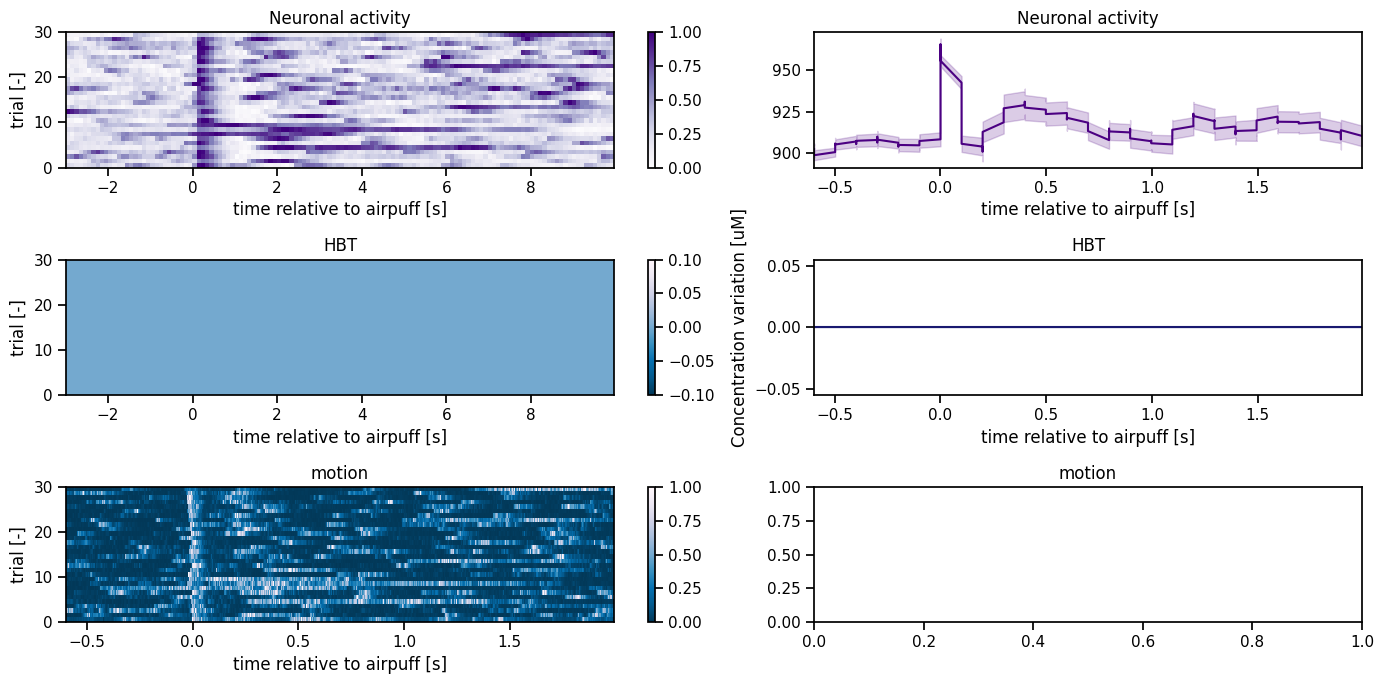

In [30]:
fig, axs = plt.subplots(3, 2, figsize=(14,7), width_ratios=[5, 4])
sns.set_context('notebook')
# print(sigs_t[0])
titles = ("Neuronal activity", "HBT", "motion")
cols = ('indigo', 'midnightblue', 'midnightblue')
cmaps = (clm['Purples'], clm['PuBu_r'], clm['PuBu_r'])
# time = blue_t

for idx, (sig, sig_t, cmap, title) in enumerate(zip(aligned_data, sigs_t, cmaps, titles)):
  time = sig_t
  ax = plt.subplot(3, 2, 2*idx+1)
  ax.set_title(title)
  ax.set_xlabel('time relative to airpuff [s]')
  ax.set_ylabel("trial [-]")
  data = aligned_data_norm[idx][:,:]
  pos = ax.imshow(data, origin='lower', extent=[time[AP_idx[idx][0]-inf]-time[AP_idx[idx][0]], time[AP_idx[idx][0]+sup]-time[AP_idx[idx][0]], 0, len(AP_times)], aspect='auto', cmap=cmap)
  fig.colorbar(pos, ax=ax)

for idx, (sig, col, title) in enumerate(zip(aligned_data_raw, cols, titles)):
    avg_data = np.mean(sig, axis=0)
    std_data = sem(sig, axis=0)

    ax = plt.subplot(3, 2, 2*idx+2)
    ax.set_title(title)
    # ax.vlines(0, avg_data.min(), avg_data.max(), color='grey', linestyles='-')
    ax.plot(time[AP_idx[idx][0]-inf:AP_idx[idx][0]+sup]-time[AP_idx[idx][0]], avg_data, color=col)
    ax.fill_between(time[AP_idx[idx][0]-inf:AP_idx[idx][0]+sup]-time[AP_idx[idx][0]], avg_data-std_data, avg_data+std_data, color=col, alpha=0.2)
    ax.set_xlim(time[AP_idx[idx][0]-inf]-time[AP_idx[idx][0]], time[AP_idx[idx][0]+sup]-time[AP_idx[idx][0]])
    ax.set_xlabel('time relative to airpuff [s]')
    if idx == 1:
        ax.set_ylabel("Concentration variation [uM]")
    # sns.despine()
    plt.tight_layout()